In [1]:
import torch as t
import torch.nn as nn
import torchvision 
import torch.utils.data as Date
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable as V

In [2]:
t.manual_seed(1)

In [3]:
EPOCH=1
BATCH_SIZE=50
LR=0.001
DOWN_MNIST=False
data_trian=torchvision.datasets.MNIST(root='./mnist/',train=True,transform=torchvision.transforms.ToTensor,download=False)
data_test=torchvision.datasets.MNIST(root='./mnist/',train=False,transform=torchvision.transforms.ToTensor,download=False)
train_x = V(t.unsqueeze(data_trian.train_data,dim=1)).type(t.FloatTensor)/255
train_y= data_trian.train_labels
test_x = V(t.unsqueeze(data_test.test_data,dim=1)).type(t.FloatTensor)[:2000]/255
test_y = data_test.test_labels[:2000]
train_data=Date.TensorDataset(train_x,train_y)
train_loader=Date.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, stride, 1, bias=False), # bias=False是因為bias再BN中已經有了，如果stride=2則shape會變成一半
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False), # shape前後仍然一漾
            nn.BatchNorm2d(out_channel),
        )
        
        self.right = shortcut #根據情況是否做出增維或是縮小shape
        
    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out = out + residual
        out = F.relu(out)
        return out

    
    
class ResNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet, self).__init__()
        
        self.pre_layer = nn.Sequential(
            nn.Conv2d(1, 64, 7, 2, 3, bias=False), #為了使shape變一半，stride必須是2，在固定kernel=7下由公式推得padding=3
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1) , #為了使shape變一半，stride必須是2，在固定kernel=3下由公式推得padding=1
        )
        
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 4, stride=2) # 對照架構圖，第二段後每次都會將shape再度縮小一半
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def _make_layer(self, in_channel, out_channel, block_num, stride=1):
        
        # shortcut的部份必須和該block最後一層維度相同，所以這裡做1d conv增加維度
        # 並且根據有沒有縮小shape(stride=2)做相同的動作
        shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel,  1, stride, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        
        layers = []
        
        
        if out_channel==64:
             layers.append(ResidualBlock(in_channel,out_channel,stride))
        else:
            layers.append(ResidualBlock(in_channel,out_channel,stride,shortcut))
        # 第一次的ResidualBlock可能會縮小shape(根據stride)，所以要獨立出來做
        
        
        #注意這邊都是第二次以後的ResidualBlock，所以不會有維度或大小不同的問題，參數跟shortcut都不用做
        for i in range(1, block_num):
            layers.append(ResidualBlock(out_channel, out_channel))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        #print('origin:', x.shape) # (batch, channel, w, h)
        
        x = self.pre_layer(x)
        #print('pre_layer:', x.shape) # (batch, channel, w, h) -> # (batch, 64, w/4, h/4)
        
        x = self.layer1(x)
        #print('layer1:', x.shape) # (batch, 64, w/4, h/4) -> (batch, 64, w/4, h/4)
        
        x = self.layer2(x)
        #print('layer2:', x.shape) # (batch, 64, w/4, h/4) -> (batch, 128, w/8, h/8)
        
        x = self.layer3(x)
        #print('layer3:', x.shape) # (batch, 128, w/8, h/8) -> (batch, 256, w/16, h/16)
        
        x = self.layer4(x)
        #print('layer4:', x.shape) # (batch, 256, w/16, h/16) -> (batch, 512, w/32, h/32)
        
        x = F.avg_pool2d(x, x.shape[3]) 
        #print('avg_pool:', x.shape) # (batch, 512, w/32, h/32) -> (batch, 512, 1, 1)
        
        x = x.view(x.size(0), -1) # (batch, 512, 1, 1) -> (batch, 512 * 1 * 1)
        #print('flatten:', x.shape)
        
        out = self.fc1(x)
        out = self.fc2(out)
        return out    


In [5]:
print(ResNet())

ResNet(
  (pre_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [6]:
resNet=ResNet()

In [7]:
optimizer=t.optim.Adam(resNet.parameters(),lr=LR)
loss_func=nn.CrossEntropyLoss()
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

In [8]:
Epoch=0
for epoch in range(2):
    
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = V(x)   # batch x
        b_y = V(y)   # batch y
        
        output = resNet(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
        b_t_x= V(test_x)
        b_t_y= V(test_y)
        
        
        
        
        
        if step % 100 == 0:
            resNet.eval()
            Epoch+=1
            test_output = resNet(test_x) 
            resNet.train()
            pred_y = t.max(test_output, 1)[1]#因為是relu，所以max取機率最高的機率
            tran_pred_y = t.max(output, 1)[1]
            
            training_loss.append(loss.data)
            val_loss = loss_func(test_output, b_t_y)
            validation_loss.append(val_loss.data)
            
            
            
            
            
            tran_accuracy = (tran_pred_y == y).sum().item() / float(y.size(0))
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            training_accuracy.append(tran_accuracy)
            validation_accuracy.append(accuracy)
            
            
            print('Epoch: ', Epoch, '| train accuracy: %.2f' % tran_accuracy, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy, '- test loss: %.4f' % val_loss.item())


Epoch:  1 | train accuracy: 0.18 | train loss: 2.2980 | test accuracy: 0.09 - test loss: 2.3029
Epoch:  2 | train accuracy: 0.96 | train loss: 0.1669 | test accuracy: 0.73 - test loss: 1.3465
Epoch:  3 | train accuracy: 0.98 | train loss: 0.0967 | test accuracy: 0.84 - test loss: 0.6134
Epoch:  4 | train accuracy: 0.94 | train loss: 0.2419 | test accuracy: 0.74 - test loss: 1.0561
Epoch:  5 | train accuracy: 0.98 | train loss: 0.0649 | test accuracy: 0.92 - test loss: 0.2891
Epoch:  6 | train accuracy: 0.94 | train loss: 0.4191 | test accuracy: 0.96 - test loss: 0.1548
Epoch:  7 | train accuracy: 1.00 | train loss: 0.0164 | test accuracy: 0.92 - test loss: 0.2871
Epoch:  8 | train accuracy: 0.98 | train loss: 0.0625 | test accuracy: 0.96 - test loss: 0.1235
Epoch:  9 | train accuracy: 0.98 | train loss: 0.0997 | test accuracy: 0.94 - test loss: 0.2227
Epoch:  10 | train accuracy: 1.00 | train loss: 0.0201 | test accuracy: 0.95 - test loss: 0.1722
Epoch:  11 | train accuracy: 0.98 | tra

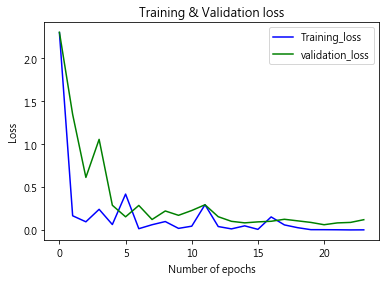

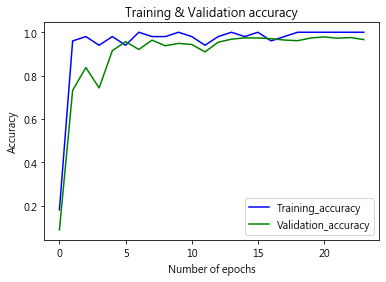

In [9]:
plt.plot(training_loss, 'b-', label='Training_loss')
plt.plot(validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot( training_accuracy, 'b-', label='Training_accuracy')
plt.plot( validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
y_0_9_chance=resNet(test_x[:20])
y_pred=t.max(y_0_9_chance,1)[1].data.numpy().squeeze()
print('實際:',test_y[:20].numpy())
print('預測:',y_pred)

實際: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
預測: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [11]:
from sklearn.metrics import classification_report
y_all=resNet(test_x)
y_pred_all=t.max(y_all,1)[1].data.numpy().squeeze()
target_names = ['0', '1', '2','3','4','5','6','7','8','9']
print(classification_report(test_y.numpy(),y_pred_all,target_names=target_names))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       175
           1       0.99      0.99      0.99       234
           2       0.99      0.99      0.99       219
           3       0.99      0.99      0.99       207
           4       0.99      0.98      0.98       217
           5       0.98      0.99      0.98       179
           6       0.99      0.97      0.98       178
           7       0.97      1.00      0.99       205
           8       0.99      0.98      0.98       192
           9       0.98      0.98      0.98       194

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [12]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=test_y.numpy(), y_pred=y_pred_all)
print(confmat)

[[175   0   0   0   0   0   0   0   0   0]
 [  0 232   0   1   0   0   0   1   0   0]
 [  0   1 216   0   0   0   0   2   0   0]
 [  0   0   0 204   0   2   0   1   0   0]
 [  0   0   1   0 212   0   1   0   0   3]
 [  0   0   0   1   0 177   0   0   1   0]
 [  3   0   0   0   0   1 173   0   1   0]
 [  0   0   0   0   0   0   0 205   0   0]
 [  0   1   1   1   0   0   0   1 188   0]
 [  0   0   0   0   2   1   0   1   0 190]]
